# Reading Parquet Metadata

[Apache Parquet](https://parquet.apache.org/) is a common output format for distributed data pipelines, for example Spark and Presto. The files contain a lot of metadata about the contents of the file which can be useful to understand the data before querying it.

In our usecase we're going to get metadata from the [Common Crawl Columnar Index](https://commoncrawl.org/2018/03/index-to-warc-files-and-urls-in-columnar-format/) to help find which Parquet files contain an index to specific URLs.


## Using [pyarrow dataset](https://arrow.apache.org/docs/python/dataset.html)

Pyarrow provides excellent support for Parquet and makes it easy to read the metadata.

In [1]:
import pyarrow.dataset as ds
import pyarrow as pa

It only takes 16s to find all the partition data. (Note that you will need an Amazon Web Services account configured to run this because [it requires authentication](https://commoncrawl.org/2022/03/introducing-cloudfront-access-to-common-crawl-data/)).

In [2]:
%%time
cc_index_s3_path = 's3://commoncrawl/cc-index/table/cc-main/warc/'

cc_index = ds.dataset(cc_index_s3_path, format='parquet', partitioning='hive')

CPU times: user 3.14 s, sys: 512 ms, total: 3.65 s
Wall time: 16.9 s


We can access individual files.

In [3]:
cc_index.files[-1]

'commoncrawl/cc-index/table/cc-main/warc/crawl=CC-MAIN-2022-05/subset=warc/part-00299-1e2959d8-5649-433a-b76e-f1b876a6479d.c000.gz.parquet'

There's also the `get_fragments` interface which returns pointers to the original files, but has additional methods and can be filtered.

For example we can list all the WARC files.

In [4]:
%%time
fragments = list(cc_index.get_fragments(filter=ds.field('subset') == 'warc'))
n_warc = len(fragments)
n_warc

CPU times: user 138 ms, sys: 3.61 ms, total: 142 ms
Wall time: 145 ms


25193

Here we just get the fragments for the WARC data from the 2022-05 crawl; which is 300 Parquet files.

In [5]:
%%time
fragments = list(cc_index.get_fragments(filter=(ds.field('crawl') == 'CC-MAIN-2022-05') &
                                        (ds.field('subset') == 'warc')))
len(fragments)

CPU times: user 7.51 ms, sys: 716 µs, total: 8.23 ms
Wall time: 8.22 ms


300

Each fragment consists of an individual parquet file.

In [6]:
fragments[0].path

'commoncrawl/cc-index/table/cc-main/warc/crawl=CC-MAIN-2022-05/subset=warc/part-00000-1e2959d8-5649-433a-b76e-f1b876a6479d.c000.gz.parquet'

A Parquet file is split into row groups.

In [7]:
fragments[0].row_groups

[RowGroupInfo(0),
 RowGroupInfo(1),
 RowGroupInfo(2),
 RowGroupInfo(3),
 RowGroupInfo(4),
 RowGroupInfo(5),
 RowGroupInfo(6),
 RowGroupInfo(7),
 RowGroupInfo(8),
 RowGroupInfo(9),
 RowGroupInfo(10)]

These row groups contain some statistics.
In particular it's approximately sorted by `url_surtkey`; if we are looking for a particular URL we can exclude row groups where the URL isn't between the `min` and `max` values.

In [8]:
fragments[0].row_groups[0].statistics

{'url_surtkey': {'min': 'com,wordpress,freefall852)/2016/03/29/billy-guy',
  'max': 'com,worldpackers)/search/skill_hospitality_entertainment/type_hotel?location_categories[]=nature&location_types[]=hotel&min_meals_count[]=3&months[]=11&skills[]=music'},
 'url': {'min': 'http://03.worldchefsbible.com/',
  'max': 'https://zh.worldallianceofdramatherapy.com/he-mission'},
 'url_host_name': {'min': '03.worldchefsbible.com',
  'max': 'zr1.worldblast.com'},
 'url_host_tld': {'min': 'com', 'max': 'com'},
 'url_host_2nd_last_part': {'min': 'wordpress', 'max': 'worldpackers'},
 'url_host_3rd_last_part': {'min': '03', 'max': 'zr1'},
 'url_host_4th_last_part': {'min': 'bbbfoundation', 'max': 'www'},
 'url_host_5th_last_part': {'min': 'http', 'max': 'toolbox'},
 'url_host_registry_suffix': {'min': 'com', 'max': 'com'},
 'url_host_registered_domain': {'min': 'wordpress.com',
  'max': 'worldpackers.com'},
 'url_host_private_suffix': {'min': 'com', 'max': 'com'},
 'url_host_private_domain': {'min': '

In [9]:
fragments[0].row_groups[0].id

0

In [10]:
fragments[0].row_groups[0].num_rows

1730100

In [11]:
(25_000 /3) / 60

138.88888888888889

We can go ahead an iterate through all the fragments and extract the row-group data.

Around 2-3/second.

In [12]:
from tqdm.auto import tqdm
from time import time

N = 20
start_time = time()

row_group_statistics = []
for i, f in tqdm(enumerate(fragments), total=len(fragments)):
    for row_group in f.row_groups:
        row_group_statistics.append(
            {'bucket': f.path.split('/', maxsplit=1)[0],
             'key': f.path.split('/', maxsplit=1)[1],
             'id': row_group.id,
             'num_rows': row_group.num_rows,
             'min_url_surtkey': row_group.statistics['url_surtkey']['min'],
             'max_url_surtkey': row_group.statistics['url_surtkey']['min'],
            })
    if i >= N:
        break
        
elapsed_time = time() - start_time
elapsed_time

  0%|          | 0/300 [00:00<?, ?it/s]

7.918716907501221

Processing all the files would take around this many minutes:

In [13]:
(elapsed_time * n_warc / N) / 60

166.2468625422319

It seems to take an unusually long time to read the row_group statistics.

## Using fastparquet

[Fastparquet](https://github.com/dask/fastparquet/) is another system to read Parquet files creates by the [Dask Project](https://dask.org/).

For remote files we need to pass the fsspec filesystem; in this case using s3fs.

In [14]:
from fastparquet import ParquetFile
import s3fs

fs = s3fs.S3FileSystem()

It's quite slow and takes seconds to even access a single file (this just reads the metadata, no data is loaded).
It seems like we can pass the whole `cc_index_s3_path`, but it would take prohibitively long to process.
Perhaps this would be better if the compute was located closer to the data (this is being run on a laptop in Australia).

In [15]:
%%time
pf = ParquetFile(fn=fragments[0].path, fs=fs)

CPU times: user 176 ms, sys: 56.6 ms, total: 232 ms
Wall time: 2.33 s


We can access all the statistics through the `fmd` attribue (file meta data).

In [16]:
pf.fmd.row_groups[0].columns[0].meta_data._asdict()

{'type': 6,
 'encodings': [0, 4],
 'path_in_schema': ['url_surtkey'],
 'codec': 2,
 'num_values': 1730100,
 'total_uncompressed_size': 117917394,
 'total_compressed_size': 23113472,
 'key_value_metadata': None,
 'data_page_offset': 4,
 'index_page_offset': None,
 'dictionary_page_offset': None,
 'statistics': {'max': None,
  'min': None,
  'null_count': 0,
  'distinct_count': None,
  'max_value': "b'com,worldpackers)/search/skill_hospitality_entertainment/type_hotel?location_categories[]=nature&location_types[]=hotel&min_meals_count[]=3&months[]=11&skills[]=music'",
  'min_value': "b'com,wordpress,freefall852)/2016/03/29/billy-guy'"},
 'encoding_stats': [{'page_type': 0, 'encoding': 0, 'count': 122}],
 'bloom_filter_offset': None}

# Directly reading Parquet metadata

Apache Arrow datasets and fastparquet are convenient, but they are slow. Let's see what it takes to read Parquet metadata.

Looking at the Apache Parquet [file format](https://parquet.apache.org/docs/file-format/) the file metadata is at the end of the file, followed by a 4 byte integer describing the metadata length and then 4 bytes with the magic number "PAR1".

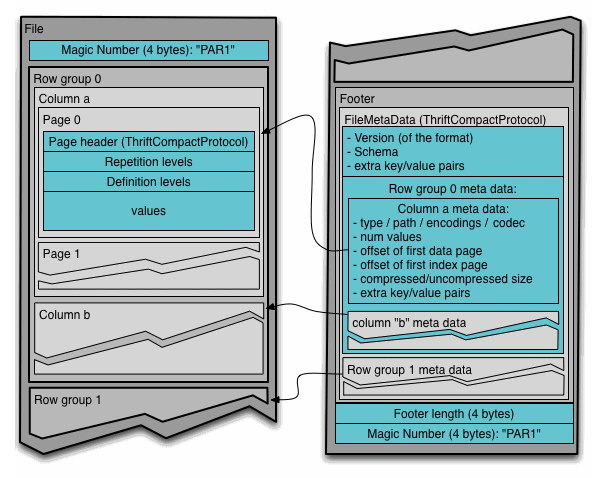

S3 has a HTTP REST interface; while we could use it directly we will access it through boto to abstract away things like authentication.

In [17]:
import boto3

s3 = boto3.client('s3')

Let's start with a single parquet file

In [18]:
file = fragments[0].path
file

'commoncrawl/cc-index/table/cc-main/warc/crawl=CC-MAIN-2022-05/subset=warc/part-00000-1e2959d8-5649-433a-b76e-f1b876a6479d.c000.gz.parquet'

For Boto we need to separate out the bucket (commoncrawl), from the key (the rest)

In [19]:
bucket, key = file.split('/', 1)

## Getting the file metadata

Reading in the whole file is going to be slow, so we need to work out where the end of the file is; that is we need to know the file's length.
For a start we're going to need a way of working out where the end of the file is; that is it's length.

We can use a HTTP [HEAD](https://developer.mozilla.org/en-US/docs/Web/HTTP/Methods/HEAD) request, which should return the [Content-Length](https://www.w3.org/Protocols/rfc2616/rfc2616-sec14.html#sec14.13); the size of the file in bytes (8 bits).


In [20]:
%time metadata = s3.head_object(Bucket=bucket, Key=key)

CPU times: user 27.4 ms, sys: 7.98 ms, total: 35.4 ms
Wall time: 1.01 s


In [21]:
metadata

{'ResponseMetadata': {'RequestId': '6AWKV1DJNRTEER3W',
  'HostId': 'YtP3flNoav+Ht8NgTRWGNrbeXXvkPbpH2+C1Xo8m2gcD4e9gbZQBazEVnozbS0qEdMXZg4XvQ1g=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'YtP3flNoav+Ht8NgTRWGNrbeXXvkPbpH2+C1Xo8m2gcD4e9gbZQBazEVnozbS0qEdMXZg4XvQ1g=',
   'x-amz-request-id': '6AWKV1DJNRTEER3W',
   'date': 'Mon, 18 Apr 2022 12:23:58 GMT',
   'last-modified': 'Sun, 30 Jan 2022 05:01:16 GMT',
   'etag': '"45ca767a5b7c8226dd75be1b8bb525f0"',
   'x-amz-storage-class': 'INTELLIGENT_TIERING',
   'accept-ranges': 'bytes',
   'content-type': 'application/octet-stream',
   'server': 'AmazonS3',
   'content-length': '1344281529'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2022, 1, 30, 5, 1, 16, tzinfo=tzutc()),
 'ContentLength': 1344281529,
 'ETag': '"45ca767a5b7c8226dd75be1b8bb525f0"',
 'ContentType': 'application/octet-stream',
 'Metadata': {},
 'StorageClass': 'INTELLIGENT_TIERING'}

The whole file is quite large to read in at once, and there are 300 of them!

In [22]:
content_length = int(metadata['ContentLength'])
f'{content_length / (1024**3):0.1f} GB'

'1.3 GB'

We can just read in the last 8 bytes by passing Range to get_object, which under the hood is using a HTTP [Range Requst](https://developer.mozilla.org/en-US/docs/Web/HTTP/Range_requests).

In [23]:
end_byte = content_length
start_byte = end_byte - 8

In [24]:
%%time
response = s3.get_object(Bucket=bucket, Key=key, Range=f'bytes={start_byte}-{end_byte}')
end_content = response['Body'].read()
end_content

CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 258 ms


b'o\xe5\x00\x00PAR1'

The end is the magic number for the Parquet format.

In [25]:
assert end_content[-4:] == b'PAR1'

This is preceeded by the length of the metadata in bytes.

In [26]:
file_meta_length = int.from_bytes(end_content[:4], byteorder='little')
f'{file_meta_length / 1024:0.1f} kb'

'57.4 kb'

Now we know how long the metadata is we can read it from the file.

In [27]:
end_byte = content_length - 8
start_byte = content_length - 8 - file_meta_length

Note this takes just a little longer than reading 2 bytes; there's a relatively high constant overhead per request.

In [28]:
%%time
response = s3.get_object(Bucket=bucket, Key=key, Range=f'bytes={start_byte}-{end_byte}')
file_meta_content = response['Body'].read()

CPU times: user 5.33 ms, sys: 4.37 ms, total: 9.7 ms
Wall time: 496 ms


## Decoding file metadata

The Apache Parquet [metadata documentation](https://parquet.apache.org/docs/file-format/metadata/) shows the format of the file metadata, which we can parse.

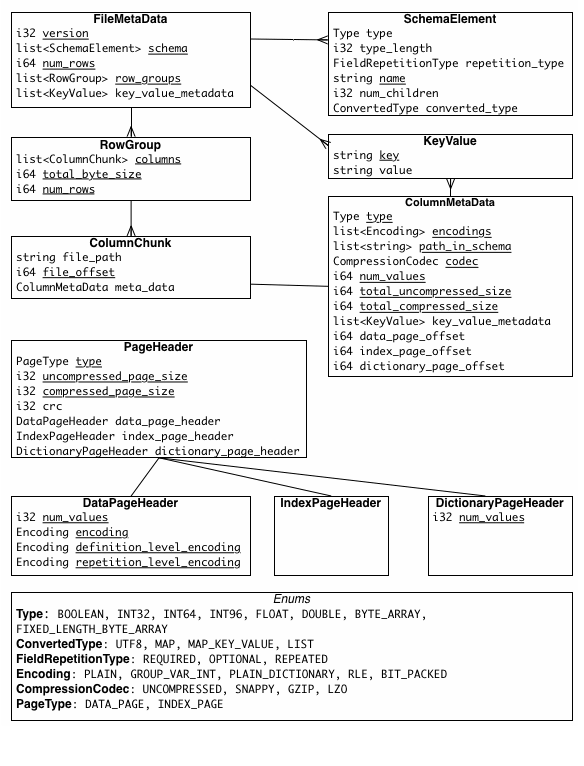

This is pretty involved, so I'll cheat and use the good work of fastparquet to read the metadata for me.

In [29]:
from fastparquet.cencoding import from_buffer

fmd = from_buffer(file_meta_content, "FileMetaData")

It's using [Apache Thrift](https://thrift.apache.org/) for the file metadata.

In [30]:
type(fmd)

fastparquet.cencoding.ThriftObject

We can then extract these fields as attributes; like the version

In [31]:
dir(fmd)

['column_orders',
 'created_by',
 'encryption_algorithm',
 'footer_signing_key_metadata',
 'key_value_metadata',
 'num_rows',
 'row_groups',
 'schema',
 'version']

In [32]:
fmd.version

1

Or the schema

In [33]:
fmd.schema[0]

{'type': None, 'type_length': None, 'repetition_type': None, 'name': "b'spark_schema'", 'num_children': 30, 'converted_type': None, 'scale': None, 'precision': None, 'field_id': None, 'logicalType': None}

In [34]:
fmd.schema[1]

{'type': 6, 'type_length': None, 'repetition_type': 0, 'name': "b'url_surtkey'", 'num_children': None, 'converted_type': 0, 'scale': None, 'precision': None, 'field_id': None, 'logicalType': {'STRING': {}, 'MAP': None, 'LIST': None, 'ENUM': None, 'DECIMAL': None, 'DATE': None, 'TIME': None, 'TIMESTAMP': None, 'INTEGER': None, 'UNKNOWN': None, 'JSON': None, 'BSON': None, 'UUID': None}}

And the row groups

In [35]:
fmd.row_groups[0].total_byte_size

452304596

In [36]:
fmd.row_groups[0].columns[0].meta_data._asdict()

{'type': 6,
 'encodings': [0, 4],
 'path_in_schema': ['url_surtkey'],
 'codec': 2,
 'num_values': 1730100,
 'total_uncompressed_size': 117917394,
 'total_compressed_size': 23113472,
 'key_value_metadata': None,
 'data_page_offset': 4,
 'index_page_offset': None,
 'dictionary_page_offset': None,
 'statistics': {'max': None,
  'min': None,
  'null_count': 0,
  'distinct_count': None,
  'max_value': "b'com,worldpackers)/search/skill_hospitality_entertainment/type_hotel?location_categories[]=nature&location_types[]=hotel&min_meals_count[]=3&months[]=11&skills[]=music'",
  'min_value': "b'com,wordpress,freefall852)/2016/03/29/billy-guy'"},
 'encoding_stats': [{'page_type': 0, 'encoding': 0, 'count': 122}],
 'bloom_filter_offset': None}

And the location of each column

In [37]:
fmd.row_groups[1].columns[0].file_offset

134217728

## Putting it together

We can combine all of this into a single function.

In [38]:
def parquet_metadata_s3(path, s3):
    metadata = s3.head_object(Bucket=bucket, Key=key)
    content_length = int(metadata['ContentLength'])
    
    end_response = s3.get_object(Bucket=bucket, Key=key, Range=f'bytes={content_length-8}-{content_length}')
    end_content = end_response['Body'].read()
    
    if end_content[-4:] != b'PAR1':
        raise ValueError('File at %s does not look like a Parquet file; magic %s' % (path, end_content[-4:]))
    file_meta_length = int.from_bytes(end_content[:4], byteorder='little')

    file_meta_response = s3.get_object(Bucket=bucket, Key=key,
                                       Range=f'bytes={content_length-8-file_meta_length}-{content_length-8}')
    file_meta_content = file_meta_response['Body'].read()
    
    fmd = from_buffer(file_meta_content, "FileMetaData")
    
    return fmd

This is quicker than fastparquet (although perhaps doing less), and a little faster than pyarrow.

In [39]:
%time fmd = parquet_metadata_s3(file, s3)

CPU times: user 22 ms, sys: 258 µs, total: 22.2 ms
Wall time: 1.02 s


## Using HTTP

Common Crawl also exposes a [HTTP Interface](https://commoncrawl.org/2022/03/introducing-cloudfront-access-to-common-crawl-data/) to the S3 buckets hosted using AWS CloudFront.
We can try to access those instead.

### Using Pyarrow

Pyarrow can read the files from anything that supports fsspec, and so we can pass a HTTPFileSystem.

In [40]:
from fsspec.implementations.http import HTTPFileSystem

http = HTTPFileSystem()

However it can't discover the partitions and files because there is no way to list them over HTTP; only the individual files can be accessed.
We can manually pass the files however.

In [41]:
http_files = ['https://data.commoncrawl.org/' + x.split('/', 1)[1] for x in cc_index.files]
http_files[0]

'https://data.commoncrawl.org/cc-index/table/cc-main/warc/crawl=CC-MAIN-2013-20/subset=warc/part-00000-6ac52f25-05a1-4998-adf1-b8c830c08eec.c000.gz.parquet'

In [42]:
%%time
cc_index_http = ds.dataset(http_files, format='parquet', partitioning='hive', filesystem=http)

CPU times: user 1.16 s, sys: 110 ms, total: 1.27 s
Wall time: 2.97 s


In [43]:
%%time
fragments_http = list(cc_index_http.get_fragments())

CPU times: user 296 ms, sys: 0 ns, total: 296 ms
Wall time: 294 ms


This runs at a similar rate to S3.

In [44]:
from tqdm.auto import tqdm
from time import time

N = 20
start_time = time()

row_group_statistics = []
for i, f in tqdm(enumerate(fragments_http), total=len(fragments_http)):
    for row_group in f.row_groups:
        row_group_statistics.append(
            {'bucket': f.path.split('/', maxsplit=1)[0],
             'key': f.path.split('/', maxsplit=1)[1],
             'id': row_group.id,
             'num_rows': row_group.num_rows,
             'min_url_surtkey': row_group.statistics['url_surtkey']['min'],
             'max_url_surtkey': row_group.statistics['url_surtkey']['min'],
            })
    if i >= N:
        break
        
elapsed_time = time() - start_time
elapsed_time

  0%|          | 0/60585 [00:00<?, ?it/s]

31.016972541809082

###  Accessing HTTP endpoint directly

This is essentially the same as the S3 Boto version.

In [45]:
import requests

def parquet_metadata_http(url, session=requests):
    metadata = session.head(url)
    metadata.raise_for_status()
    content_length = int(metadata.headers['Content-Length'])
    
    end_response = requests.get(url, headers={"Range": f'bytes={content_length-8}-{content_length}'})
    end_response.raise_for_status()
    end_content = end_response.content
    
    if end_content[-4:] != b'PAR1':
        raise ValueError('File at %s does not look like a Parquet file; magic %s' % (path, end_content[-4:]))
    file_meta_length = int.from_bytes(end_content[:4], byteorder='little')

    file_meta_response = requests.get(url, headers={"Range": f'bytes={content_length-8-file_meta_length}-{content_length-8}'})
    file_meta_response.raise_for_status()
    file_meta_content = file_meta_response.content
    
    fmd = from_buffer(file_meta_content, "FileMetaData")
    
    return fmd

The result is a similar speed to the S3 version.

In [46]:
%time fmd = parquet_metadata_http(http_files[0])

CPU times: user 91.9 ms, sys: 0 ns, total: 91.9 ms
Wall time: 1.59 s


# Speeding up with asyncio

Most of the time is spent waiting for the remote server, and transferring data over the network.
We want to do this for a very large number of files.
This is a perfect use case for asyncio; instead of waiting for each request to complete before starting the next we can switch to running a new request while the first is waiting.

I'm still learning asyncio, and I mostly adapted this [from Stackoverflow](https://stackoverflow.com/questions/57126286/fastest-parallel-requests-in-python).

In [47]:
import asyncio
import aiohttp

async def _async_parquet_metadata_http(url, session):
    async with session.head(url) as response:
        await response.read()
        output_headers = response.headers
        content_length = int(output_headers['Content-Length'])
    
    headers={"Range": f'bytes={content_length-8}-{content_length}'}
    async with session.get(url=url, headers=headers) as response:
        end_content = await response.read()
    
    if end_content[-4:] != b'PAR1':
        raise ValueError('File at %s does not look like a Parquet file; magic %s' % (path, end_content[-4:]))
    file_meta_length = int.from_bytes(end_content[:4], byteorder='little')

    headers={"Range": f'bytes={content_length-8-file_meta_length}-{content_length-8}'}
    async with session.get(url, headers=headers) as response:
        file_meta_content = await response.read()
    
    fmd = from_buffer(file_meta_content, "FileMetaData")
    
    return fmd

In [48]:
from tqdm.asyncio import tqdm_asyncio

async def async_parquet_metadata_http(urls):
    async with aiohttp.ClientSession(raise_for_status=True) as session:
        ret = await tqdm_asyncio.gather(*[_async_parquet_metadata_http(url, session) for url in urls])
    return ret

This is orders of magnitude faster than running the requests sequentially.

In [49]:
import time

start_time = time.time()
metadata = await(async_parquet_metadata_http(http_files[:200]))
print(f'Ran in {time.time() - start_time:0.1f} s')

100%|██████████████████████████████████████| 200/200 [00:05<00:00, 37.98it/s]

Ran in 5.3 s


We can do a simlar thing with S3 using `aiobotocore`.

Again I don't have my head around asyncio, so this may be a terrible implementation.

In [50]:
from aiobotocore.session import get_session

async def _async_parquet_metadata_s3(path, s3):
    metadata = await s3.head_object(Bucket=bucket, Key=key)
    content_length = int(metadata['ContentLength'])
    
    end_response = await s3.get_object(Bucket=bucket, Key=key, Range=f'bytes={content_length-8}-{content_length}')
    end_content = await end_response['Body'].read()
    
    if end_content[-4:] != b'PAR1':
        raise ValueError('File at %s does not look like a Parquet file; magic %s' % (path, end_content[-4:]))
    file_meta_length = int.from_bytes(end_content[:4], byteorder='little')

    file_meta_response = await s3.get_object(Bucket=bucket, Key=key,
                                       Range=f'bytes={content_length-8-file_meta_length}-{content_length-8}')
    file_meta_content = await file_meta_response['Body'].read()
    
    fmd = from_buffer(file_meta_content, "FileMetaData")
    
    return fmd

In [51]:
async def async_parquet_metadata_s3(urls):
    session = get_session()
    async with session.create_client('s3') as s3:
        ret = await tqdm_asyncio.gather(*[_async_parquet_metadata_s3(url, s3) for url in urls])
    return ret

It's quite a bit slower than HTTP.
Since S3 has a REST API that boto3 uses I'd expect it to be a similar speed; it would be interesting to find out what is happening here.

But we can just stick to the HTTP interface.

In [52]:
import time

start_time = time.time()
metadata = await(async_parquet_metadata_s3(cc_index.files[:200]))
print(f'Ran in {time.time() - start_time:0.1f} s')

100%|██████████████████████████████████████| 200/200 [00:18<00:00, 10.54it/s]

Ran in 19.2 s


# Scaling up

What happens as we scale up to the whole index?

We are just interested in the WARC files, which there are a lot of.

In [53]:
warc_files = [f for f in cc_index.files if '/subset=warc/' in f]

num_files = len(warc_files)
num_files

25193

In [54]:
http_files = ['https://data.commoncrawl.org/' + x.split('/', 1)[1] for x in warc_files]

The total length of all the content will be around:

In [55]:
f'{(file_meta_length * num_files) / 1024**3:0.2f} GB'

'1.38 GB'

We're hitting around 50-60/s, with 3 requests per file giving a total of ~150-200 requests/second. CommonCrawl is geared towards exporting data, so this may be fine but the server may throttle us.

We're also making ~75k+ requests. There's a good chance something will go wrong.

I can think of 3 kinds of issues:

1. An intermittent issue causes an individual load to fail.
2. There is an issue with an individual file and so loading will always fail.
3. There is an environmental issue (server rejecting all requests, network down) and all requests fail.

We also don't want all 25k requests being handled simultaneously, the overhead of managing all the task switching will be too much.

A simple approach is:

1. Run a batch of N requests 
2. Capture any errors and put these jobs in a retry cue (to handle 1)
3. Remove any jobs that have been retried too many times (to handle 2)
4. If more than x% of the N requests fail abort the process (to handle 3).

Since the data is immutable we can persist the data to disk and resume. One simple solution is [sqlitedict](https://github.com/RaRe-Technologies/sqlitedict).
It makes sense to fetch the data as one step, and then extract the data afterwards (since it's harder to recover from an error in extraction).

Let's catch common exceptions and raise them

In [56]:
import asyncio
import aiohttp

from typing import Union

async def _async_parquet_metadata_http(url, session):
    """Retrieve Parquet file metadata from url using session"""
    async with session.head(url) as response:
        await response.read()
        output_headers = response.headers
        content_length = int(output_headers['Content-Length'])

    headers={"Range": f'bytes={content_length-8}-{content_length}'}
    async with session.get(url=url, headers=headers) as response:
        end_content = await response.read()

    if end_content[-4:] != b'PAR1':
        raise ValueError('File at %s does not look like a Parquet file; magic %s' % (path, end_content[-4:]))
    file_meta_length = int.from_bytes(end_content[:4], byteorder='little')

    headers={"Range": f'bytes={content_length-8-file_meta_length}-{content_length-8}'}
    async with session.get(url, headers=headers) as response:
        file_meta_content = await response.read()
    return file_meta_content

In [57]:
async def fetch_parquet_metadata_http(urls):
    async with aiohttp.ClientSession(raise_for_status=True) as session:
        ret = await asyncio.gather(*[_async_parquet_metadata_http(url, session) for url in urls], return_exceptions=True)
    return ret

Let's open a fresh sqlitedict dropping any existing data (in practice we would keep this between sessions, since the data shouldn't change).

In [58]:
from sqlitedict import SqliteDict

metadata_store = SqliteDict('common_crawl_columnar_index_metadata.sqlite', flag='w')

Let's configure our run and set up some datastructures for tracking.

We will only process jobs that aren't in the metadata_store.

In [59]:
from collections import defaultdict

max_retries = 3
max_exceptions_per_batch = 5
batch_size = 1000

retries = defaultdict(int)
exceptions = defaultdict(list)
seen = set(metadata_store.keys())

jobs = [x for x in http_files if x not in seen]
len(jobs)

25193

We can now run through all the jobs

In [60]:
start_time = time.time()

with tqdm(total=len(jobs)) as pbar:
    while len(jobs) > 0:
        batch = jobs[:batch_size]

        batch_metadata = await(fetch_parquet_metadata_http(batch))

        num_exceptions = 0

        for job, metadata in zip(batch, batch_metadata):
            if isinstance(metadata, Exception):
                num_exceptions += 1
                exceptions[job].append(metadata)
                retries[job] += 1
                if retries[job] >= max_retries:
                    jobs.remove(job)
            else:
                assert isinstance(metadata, bytes)
                metadata_store[job] = metadata
                jobs.remove(job)
                pbar.update()

        metadata_store.commit()
        if num_exceptions >= max_exceptions_per_batch:
            print('Too many exceptions %i' % num_exceptions)
            break
        
print(f'Finished in {time.time() - start_time:0.0f}s')

  0%|          | 0/25193 [00:00<?, ?it/s]

Finished in 441s


How many exceptions are raised?

In [61]:
len(retries), sum(retries.values())

(0, 0)

Now we have all the headers, we want to extract the relevant metadata.

In [62]:
def get_column_metadata(column, row_group):
    matches = [col for col in row_group.columns if col.meta_data.path_in_schema == [column]]
    if len(matches) != 1:
        raise ValueError(matches)
    return matches[0].meta_data

In [63]:
stats_columns = ['url_surtkey']

def extract_row_group_metadata(k, v):
    fmd = from_buffer(v, "FileMetaData")
    
    for idx, row_group in enumerate(fmd.row_groups):
        result = {
            'path': k[len('https://data.commoncrawl.org/'):],
            'crawl': k.split('/')[-3].split('=')[-1],
            'subset':  k.split('/')[-2].split('=')[-1],
            'row_group': idx,
            'num_rows': row_group.num_rows,
            'byte_size': row_group.total_byte_size,
        }
        for col in stats_columns:
            minimum = get_column_metadata(col, row_group).statistics.min_value 
            maximum = get_column_metadata(col, row_group).statistics.max_value
            if isinstance(minimum, bytes):
                minimum = minimum.decode('utf-8')
            if isinstance(maximum, bytes):
                maximum = maximum.decode('utf-8')
            
            result[f'min_{col}'] = minimum
            result[f'max_{col}'] = maximum
            
            
        
        yield result

In [64]:
def extract_metadata(metadata_store):
    for k, v in tqdm(metadata_store.items(), total=len(metadata_store)):
        for row in extract_row_group_metadata(k, v):
            yield row        

In [65]:
%%time
import pandas as pd

df_metadata = pd.DataFrame(extract_metadata(metadata_store))

  0%|          | 0/25193 [00:00<?, ?it/s]

CPU times: user 1min 56s, sys: 3.51 s, total: 1min 59s
Wall time: 1min 56s


In [66]:
df_metadata.head()

,path,crawl,subset,row_group,num_rows,byte_size,min_url_surtkey,max_url_surtkey
0,cc-index/table/cc-main/warc/crawl=CC-MAIN-2013...,CC-MAIN-2013-20,warc,0,1536416,609417359,"1,103,63,50)/","au,com,adelaidenow)/news/breaking-news/another..."
1,cc-index/table/cc-main/warc/crawl=CC-MAIN-2013...,CC-MAIN-2013-20,warc,1,35284,14185475,"ar,com,buscouniversidad)/maestria-en-ciencias-...","at,belvedere)/de/events/detail/die-nacht-im-zw..."
2,cc-index/table/cc-main/warc/crawl=CC-MAIN-2013...,CC-MAIN-2013-20,warc,2,1499082,638601593,"ar,com,chubb)/","at,gv,land-oberoesterreich)/cps/rde/xchg/sid-e..."
3,cc-index/table/cc-main/warc/crawl=CC-MAIN-2013...,CC-MAIN-2013-20,warc,3,1339494,551235294,"ar,com,tripadvisor)/hotel_review-g580306-d1194...","at,meinbezirk)/wien/wien-05-margareten/service"
4,cc-index/table/cc-main/warc/crawl=CC-MAIN-2013...,CC-MAIN-2013-20,warc,4,255538,97165599,"at,meinbezirk)/wien/wien-05-margareten/themen/...","at,parents)/forum/archive/index.php/t-182119.html"


In [67]:
metadata_store.close()

In [68]:
df_metadata.to_csv('common_crawl_columnar_index_metadata.csv.gz', index=False)

Between 2017-43 and 2018-43 it looks like we may not have statistics for `url_surtkey` and would have to generate them.

In [69]:
(
 df_metadata
 .groupby('crawl')
 .agg(row_groups = ('path', 'count'),
      files = ('path', 'nunique'),
      min_url = ('min_url_surtkey', 'count'),
      max_url = ('max_url_surtkey', 'count'),
     )
  .query('min_url != row_groups')
  .sort_index()
)

,row_groups,files,min_url,max_url
crawl,,,,
CC-MAIN-2017-43,2476,300,0,0
CC-MAIN-2017-47,2199,300,0,0
CC-MAIN-2017-51,2035,300,0,0
CC-MAIN-2018-05,2361,300,0,0
CC-MAIN-2018-09,2369,300,0,0
CC-MAIN-2018-13,2250,300,0,0
CC-MAIN-2018-17,2119,300,0,0
CC-MAIN-2018-22,1950,300,0,0
CC-MAIN-2018-26,2121,300,0,0


# Example usage

Let's suppose I wanted to find captures of commoncrawl.org, from 2020-24.

In [70]:
results = df_metadata.query('crawl == "CC-MAIN-2020-24" &\
min_url_surtkey <= "org,commoncrawl)/" <= max_url_surtkey')
results

,path,crawl,subset,row_group,num_rows,byte_size,min_url_surtkey,max_url_surtkey
217771,cc-index/table/cc-main/warc/crawl=CC-MAIN-2020...,CC-MAIN-2020-24,warc,0,1730100,550358211,"org,centerar,hr,ww17)/beauty/7-mitova-o-ljepot...","org,copyrolexmenwatches)/pt/rolex-datejust-spe..."
217772,cc-index/table/cc-main/warc/crawl=CC-MAIN-2020...,CC-MAIN-2020-24,warc,1,1678910,513173987,"org,chambresdhotes)/espanol/chambres_d_hotes/d...","org,cpdl)/wiki/index.php?action=history&title=..."
217773,cc-index/table/cc-main/warc/crawl=CC-MAIN-2020...,CC-MAIN-2020-24,warc,2,1908748,583011770,"org,chinafia)/about/2-cn.html","org,crchina)/constitution-of-the-peoples-repub..."
217774,cc-index/table/cc-main/warc/crawl=CC-MAIN-2020...,CC-MAIN-2020-24,warc,3,1730100,537715703,"org,cinelatinoamericano)/cineasta.aspx?cod=4892","org,cteresource)/verso/courses/8366/physical-o..."
217775,cc-index/table/cc-main/warc/crawl=CC-MAIN-2020...,CC-MAIN-2020-24,warc,4,1880100,541778479,"org,cleancitiessacramento)/photos.html","org,ctrteam)/"


In [71]:
path_to_row_groups = (
    results
    .groupby('path')
    .agg(row_groups = ('row_group', list))
    ['row_groups']
    .to_dict()
)

path_to_row_groups

{'cc-index/table/cc-main/warc/crawl=CC-MAIN-2020-24/subset=warc/part-00245-b4a094ce-c3a1-4796-8c26-d927e48e4b4a.c000.gz.parquet': [0,
  1,
  2,
  3,
  4]}

In [72]:
%%time
http_prefix = 'https://data.commoncrawl.org/'
search_ds = ds.dataset([http_prefix + path for path in path_to_row_groups], filesystem=http, format='parquet', partitioning='hive')

CPU times: user 38.8 ms, sys: 4.97 ms, total: 43.7 ms
Wall time: 1.51 s


It could make sense to parallelise this to speed it up.

In [73]:
columns = ['url', 'url_host_name', 'warc_filename', 'warc_record_offset', 'warc_record_length']


all_groups = []

with tqdm(total=len(results)) as pbar:
    for fragment in search_ds.get_fragments():
        path = fragment.path[len(http_prefix):]
        row_groups = fragment.split_by_row_group()
        for row_group_idx in path_to_row_groups[path]:
            row_group = row_groups[row_group_idx]
            data = row_group.to_table(columns=columns,
                                       filter=ds.field('url_host_name') == 'commoncrawl.org')
            if len(data) > 0:
                all_groups.append(data)
            pbar.update()

  0%|          | 0/5 [00:00<?, ?it/s]

We can then look at some URLs.

In [74]:
len(all_groups)

1

In [75]:
results = pa.concat_tables(all_groups).to_pandas()
results

,url,url_host_name,warc_filename,warc_record_offset,warc_record_length
0,http://commoncrawl.org/,commoncrawl.org,crawl-data/CC-MAIN-2020-24/segments/1590347435...,27151522,5448
1,https://commoncrawl.org/2010/10/slideshare-bui...,commoncrawl.org,crawl-data/CC-MAIN-2020-24/segments/1590348521...,286036900,5448
2,http://commoncrawl.org/2012/03/data-2-0-summit/,commoncrawl.org,crawl-data/CC-MAIN-2020-24/segments/1590348521...,27155726,7503
3,http://commoncrawl.org/2012/11/the-norvig-web-...,commoncrawl.org,crawl-data/CC-MAIN-2020-24/segments/1590348521...,25681807,6307
4,https://commoncrawl.org/2012/12/blekko-donates...,commoncrawl.org,crawl-data/CC-MAIN-2020-24/segments/1590348521...,289331067,6925
...,...,...,...,...,...
60,http://commoncrawl.org/terms-of-use/,commoncrawl.org,crawl-data/CC-MAIN-2020-24/segments/1590348521...,26795983,6938
61,https://commoncrawl.org/terms-of-use/,commoncrawl.org,crawl-data/CC-MAIN-2020-24/segments/1590348521...,285700698,6982
62,http://commoncrawl.org/terms-of-use/full/,commoncrawl.org,crawl-data/CC-MAIN-2020-24/segments/1590348521...,27794892,11744
63,https://commoncrawl.org/terms-of-use/full/,commoncrawl.org,crawl-data/CC-MAIN-2020-24/segments/1590348521...,290639475,11778


Accessing a crawl

In [76]:
a = results.iloc[0]
url = 'https://data.commoncrawl.org/' + a.warc_filename
header = {"Range": f'bytes={a.warc_record_offset}-{a.warc_record_offset + a.warc_record_length}'}

r = requests.get(url, headers=header)
warc_data = r.content

We can then decompress and examine that WARC record.

In [77]:
import zlib
data = zlib.decompress(warc_data, wbits = zlib.MAX_WBITS | 16)
print(data.decode('utf-8')[:1500])

WARC/1.0
WARC-Type: response
WARC-Date: 2020-06-03T17:59:17Z
WARC-Record-ID: <urn:uuid:924c0b54-e18f-4fa2-883f-918ec07cc7aa>
Content-Length: 21001
Content-Type: application/http; msgtype=response
WARC-Warcinfo-ID: <urn:uuid:c9aa942a-7416-4367-8295-bf964f6be17a>
WARC-Concurrent-To: <urn:uuid:25e5d72e-1031-4d58-b6b0-2ae3991f5c91>
WARC-IP-Address: 104.28.20.25
WARC-Target-URI: http://commoncrawl.org/
WARC-Payload-Digest: sha1:CIBK2YFSVPNDFLXUHSKZG2SPN7UNN65W
WARC-Block-Digest: sha1:4N6PX5ISYJ76FDBCKXEFSC2H63XK2AIG
WARC-Identified-Payload-Type: text/html

HTTP/1.1 200 OK
Date: Wed, 03 Jun 2020 17:59:17 GMT
Content-Type: text/html; charset=UTF-8
X-Crawler-Transfer-Encoding: chunked
Connection: keep-alive
Set-Cookie: __cfduid=d21b8d62b496908e52ebb3973abe637321591207157; expires=Fri, 03-Jul-20 17:59:17 GMT; path=/; domain=.commoncrawl.org; HttpOnly; SameSite=Lax
X-Powered-By: PHP/5.5.9-1ubuntu4.29
Link: <http://commoncrawl.org/wp-json/>; rel="https://api.w.org/"
Link: <http://commoncrawl.org/